# Fungsi aktivasi leaky ReLU

In [801]:
import numpy as np

def leaky_relu(x, alpha=0.01):
    return np.where(x >= 0, x, alpha * x)

def elm_fit(X, target, h, W=None, lambda_val=1):
    if W is None:
        W = np.random.uniform(-.6, .6, (h, len(X[0])))
    Hinit = X @ W.T
    H = leaky_relu(Hinit)
    Ht = H.T
    
    # Menambahkan regularisasi ridge
    I = np.identity(h)
    Hp = np.linalg.inv(Ht @ H + lambda_val * I) @ Ht
    
    beta = Hp @ target
    y = H @ beta
    mape = sum(abs(y - target) / target) * 100 / len(target)

    return W, beta, mape


def elm_predict(X, W, b, round_output=False):
    Hinit = X @ W.T
    H = leaky_relu(Hinit)
    y = H @ b

    if round_output:
        y = [int(round(x)) for x in y]

    return y

### Memuat Dataset ISPU

In [802]:
import pandas as pd
from sklearn.preprocessing import minmax_scale

# Memuat data dari file CSV menggunakan Pandas
DKI2 = pd.read_excel("D:\Data\Kuliah\TA\Projek-TA\DATA\Classification\DATA ISPU - classification.xlsx", sheet_name="DKI2")
DKI2['Kategori'] = DKI2['Kategori'].astype(float)
DKI2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Tanggal   2191 non-null   datetime64[ns]
 1   Wilayah   2191 non-null   object        
 2   PM10      2191 non-null   float64       
 3   SO2       2191 non-null   float64       
 4   CO        2191 non-null   float64       
 5   O3        2191 non-null   float64       
 6   NO2       2191 non-null   float64       
 7   Max       2191 non-null   float64       
 8   Critical  2113 non-null   object        
 9   Kategori  2191 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 171.3+ KB


### Memisahkan Fitur (X) dan Target (Y) & Memisahkan Data Menjadi Data Train Dan Data Testing

In [803]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

n_rows = 2192

# Mengambil kolom yang diperlukan
data = DKI2[:n_rows][['Tanggal', 'PM10', 'SO2', 'CO', 'O3', 'NO2', 'Kategori']]
#data = DKI1[['Tanggal', 'PM10', 'SO2', 'CO', 'O3', 'NO2', 'Kategori']]
# Melakukan normalisasi Min-Max pada fitur
data[['PM10', 'SO2', 'CO', 'O3', 'NO2']] = minmax_scale(data[['PM10', 'SO2', 'CO', 'O3', 'NO2']])

# Memisahkan fitur (X) dan target (Y)
X = data[['PM10', 'SO2', 'CO', 'O3', 'NO2']].values
Y = data['Kategori'].values

# Memisahkan data menjadi training set dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

#Menampilkan jumlah data Train dan Test
print("Jumlah data pada Train:", X_train.shape[0])
print("Jumlah data pada Test:", X_test.shape[0])


Jumlah data pada Train: 1752
Jumlah data pada Test: 439


### Menampilkan Hasil Prediksi Klasifikasi Data Test

In [804]:
# Melakukan pelatihan model ELM
W_test, b_test, mape_test = elm_fit(X_train, y_train, 20)

# Menggunakan model ELM untuk melakukan prediksi
predict_test = elm_predict(X_test, W_test, b_test, round_output=True)
# Membuat DataFrame untuk hasil prediksi
result_df = pd.DataFrame({'Tanggal': data['Tanggal'].iloc[X_train.shape[0]:].reset_index(drop=True),
                          'Kategori': y_test,
                          'Hasil Klasifikasi ELM': predict_test})

# Menampilkan tabel hasil prediksi
print(result_df)


       Tanggal  Kategori  Hasil Klasifikasi ELM
0   2021-10-19       2.0                      2
1   2021-10-20       2.0                      2
2   2021-10-21       2.0                      2
3   2021-10-22       1.0                      1
4   2021-10-23       3.0                      3
..         ...       ...                    ...
434 2022-12-27       2.0                      2
435 2022-12-28       2.0                      2
436 2022-12-29       2.0                      2
437 2022-12-30       2.0                      2
438 2022-12-31       1.0                      1

[439 rows x 3 columns]


### Menampilkan confusion matrix

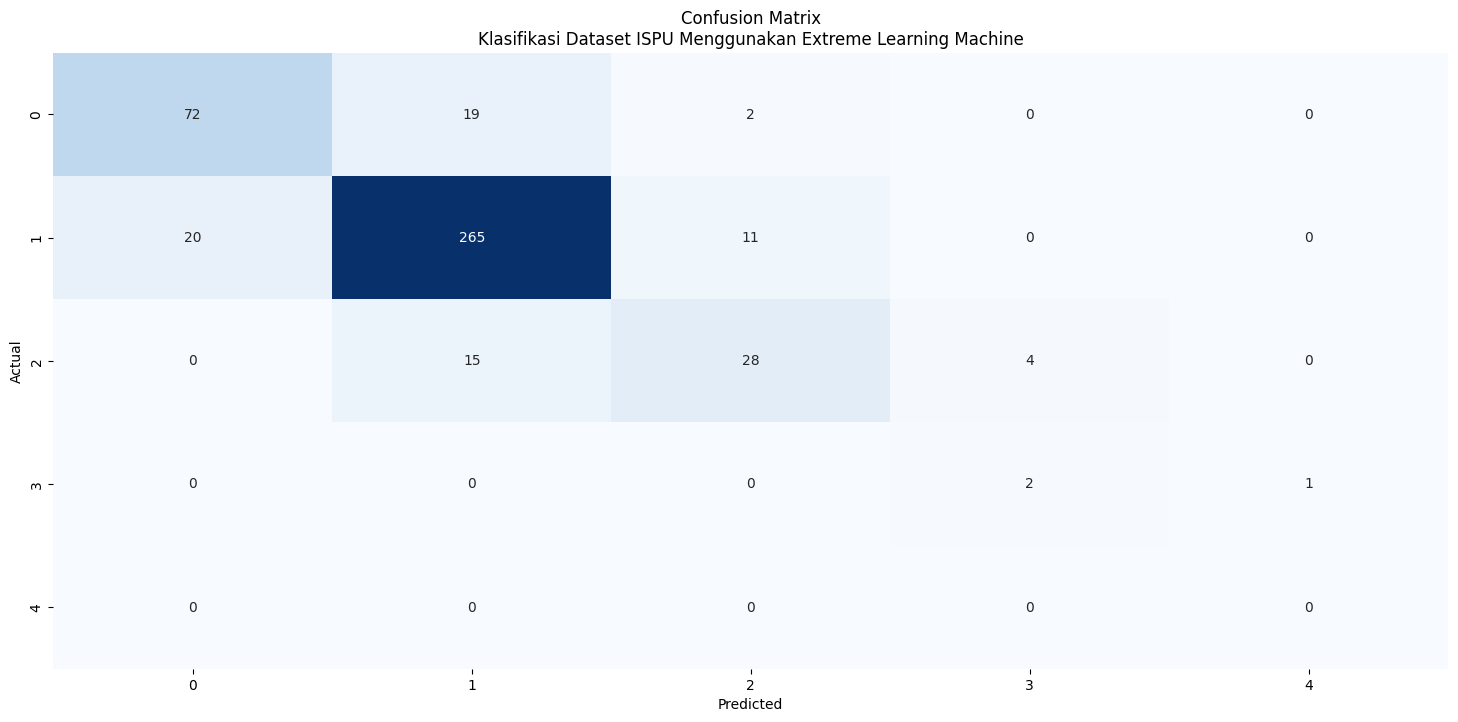

In [805]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Menghitung confusion matrix
cm = confusion_matrix(y_test, predict_test)

# Membuat plot confusion matrix
plt.figure(figsize=(18, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix\nKlasifikasi Dataset ISPU Menggunakan Extreme Learning Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Menghitung Sensitivity,Specificity,G-mean,dan Accuracy

In [806]:
# Menghitung True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Menghitung Sensitivity (True Positive Rate, Recall)
sensitivity = TP / (TP + FN)

# Menghitung Specificity
if TN + FP == 0:
    specificity = 0.0
else:
    specificity = TN / (TN + FP)

# Menghitung G-mean
if sensitivity == 0.0 or specificity == 0.0:
    g_mean = 0.0
else:
    g_mean = np.sqrt(sensitivity * specificity)

# Menghitung akurasi
accuracy = accuracy_score(predict_test, y_test)

print("Sensitivity: %.3f" % sensitivity)
print("Specificity: %.3f" % specificity)
print("G-mean: %.3f" % g_mean)
print('Accuracy: %.3f' % accuracy)

Sensitivity: 0.930
Specificity: 0.791
G-mean: 0.858
Accuracy: 0.836


### Menampilkan Hasil Prediksi Klasifikasi Data Train

In [807]:
W_train, b_train, mape_train = elm_fit(X_train, y_train, 20)
predict_train = elm_predict(X_train, W_train, b_train, round_output=True)
result_train_df = pd.DataFrame({'Tanggal': data['Tanggal'].iloc[:X_train.shape[0]].reset_index(drop=True),
                                'Kategori': y_train,
                                'Hasil Klasifikasi ELM': predict_train})
print(result_train_df)


        Tanggal  Kategori  Hasil Klasifikasi ELM
0    2017-01-01       2.0                      2
1    2017-01-02       3.0                      3
2    2017-01-03       1.0                      1
3    2017-01-04       2.0                      2
4    2017-01-05       2.0                      2
...         ...       ...                    ...
1747 2021-10-14       2.0                      2
1748 2021-10-15       2.0                      2
1749 2021-10-16       2.0                      2
1750 2021-10-17       2.0                      2
1751 2021-10-18       2.0                      2

[1752 rows x 3 columns]


### Menampilkan confusion matrix

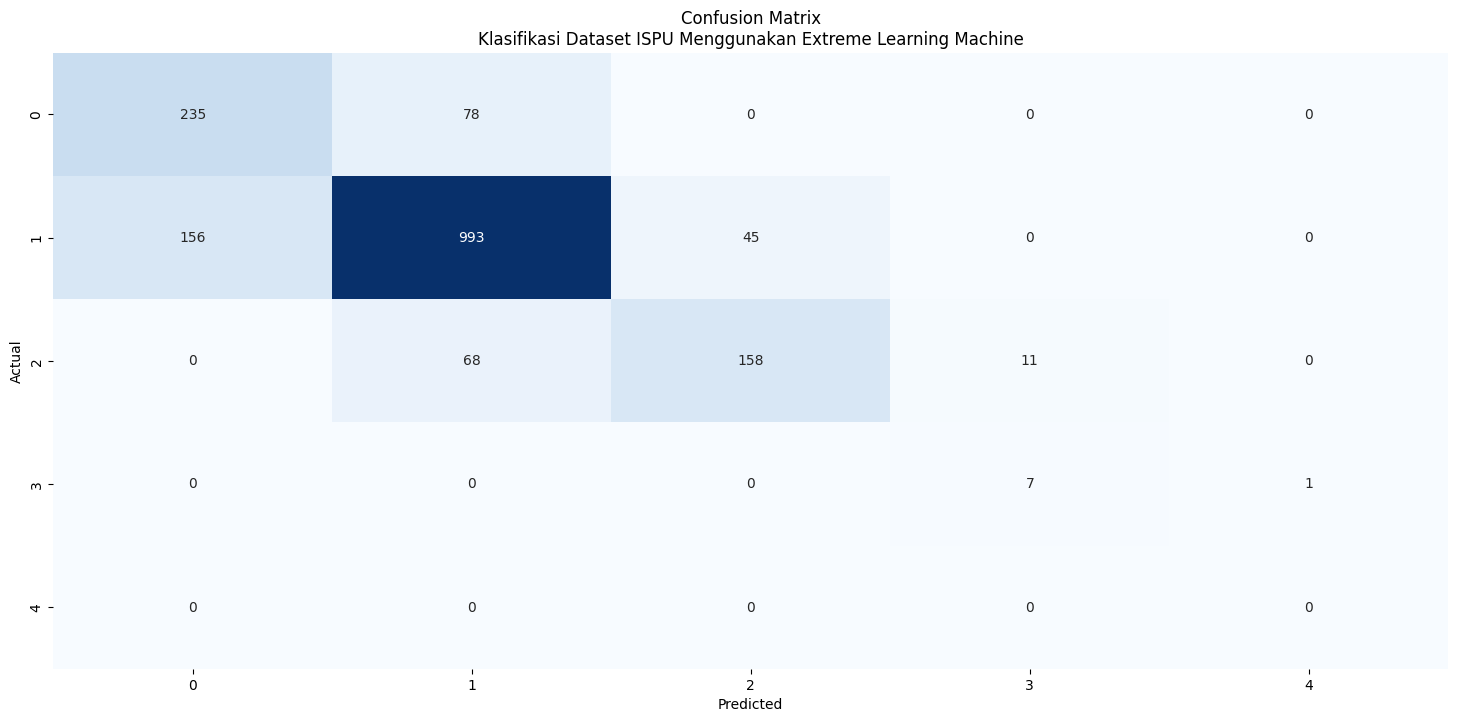

In [808]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Menghitung confusion matrix
cm = confusion_matrix(y_train, predict_train)

# Membuat plot confusion matrix
plt.figure(figsize=(18, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix\nKlasifikasi Dataset ISPU Menggunakan Extreme Learning Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Menghitung Sensitivity,Specificity,G-mean,dan Accuracy

In [809]:
# Menghitung True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Menghitung Sensitivity (True Positive Rate, Recall)
sensitivity = TP / (TP + FN)

# Menghitung Specificity
if TN + FP == 0:
    specificity = 0.0
else:
    specificity = TN / (TN + FP)

# Menghitung G-mean
if sensitivity == 0.0 or specificity == 0.0:
    g_mean = 0.0
else:
    g_mean = np.sqrt(sensitivity * specificity)

# Menghitung akurasi
accuracy = accuracy_score(predict_test, y_test)

print("Sensitivity: %.3f" % sensitivity)
print("Specificity: %.3f" % specificity)
print("G-mean: %.3f" % g_mean)
print('Accuracy: %.3f' % accuracy)

Sensitivity: 0.864
Specificity: 0.751
G-mean: 0.806
Accuracy: 0.836


### Menggabungkan hasil klasifikasi Data Train & Data Test

In [810]:
# Membuat DataFrame untuk hasil prediksi
result_df = pd.DataFrame({'Tanggal': data['Tanggal'].iloc[X_train.shape[0]:].reset_index(drop=True),
                          'Kategori': y_test,
                          'Hasil Klasifikasi ELM': predict_test})

result_train_df = pd.DataFrame({'Tanggal': data['Tanggal'].iloc[:X_train.shape[0]].reset_index(drop=True),
                                'Kategori': y_train,
                                'Hasil Klasifikasi ELM': predict_train})

#
combined_df = pd.concat([result_train_df, result_df], ignore_index=True)
print(combined_df)

        Tanggal  Kategori  Hasil Klasifikasi ELM
0    2017-01-01       2.0                      2
1    2017-01-02       3.0                      3
2    2017-01-03       1.0                      1
3    2017-01-04       2.0                      2
4    2017-01-05       2.0                      2
...         ...       ...                    ...
2186 2022-12-27       2.0                      2
2187 2022-12-28       2.0                      2
2188 2022-12-29       2.0                      2
2189 2022-12-30       2.0                      2
2190 2022-12-31       1.0                      1

[2191 rows x 3 columns]
